In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import sys

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from src.evaluation import ModelComparator
from src.feature_importance import FeatureImportanceAnalyzer

In [ ]:
DATA_DIR = Path('Data')
metrics_df = pd.read_csv(DATA_DIR / 'VED_DynamicData_Metrics.csv')
static_ice_hev = pd.read_csv(DATA_DIR / 'VED_Static_Data_ICE&HEV.csv')
static_phev_ev = pd.read_csv(DATA_DIR / 'VED_Static_Data_PHEV&EV.csv')

print(f"Metrics CSV: {metrics_df.shape}")
print(f"Static ICE/HEV: {static_ice_hev.shape}")
print(f"Static PHEV/EV: {static_phev_ev.shape}")

# Check columns in metrics_df
print(f"\nMetrics CSV columns (first 10): {metrics_df.columns.tolist()[:10]}")
print(f"Static data columns: {static_ice_hev.columns.tolist()}")

# Combine static data
static_data = pd.concat([static_ice_hev, static_phev_ev], ignore_index=True)
print(f"Combined static data: {static_data.shape}")

if 'filename' in metrics_df.columns and 'VehId' in static_data.columns:
    print("\nMetrics has 'filename' but not 'VehId'. Need to match vehicles differently.")
    print("For now, using all rows from metrics (54 vehicle-weeks)")
    data = metrics_df.copy()
    print(f"Using metrics data: {data.shape[0]} samples, {data.shape[1]} features")
else:
    # Try standard merge on VehId
    data = metrics_df.merge(static_data, on='VehId', how='inner')
    print(f"Merged data: {data.shape[0]} samples, {data.shape[1]} features")

print(f"\nData shape: {data.shape}")
print(f"Data columns (first 15): {data.columns.tolist()[:15]}")

Metrics CSV: (54, 231)
Static ICE/HEV: (357, 7)
Static PHEV/EV: (27, 7)

Metrics CSV columns (first 10): ['filename', 'VehId', 'Longitude[deg]', 'Trip', 'Timestamp(ms)', 'Latitude[deg]', 'DayNum', 'Vehicle Speed[km/h]_mean', 'Vehicle Speed[km/h]_median', 'Vehicle Speed[km/h]_std']
Static data columns: ['VehId', 'Vehicle Type', 'Vehicle Class', 'Engine Configuration & Displacement', 'Transmission', 'Drive Wheels', 'Generalized_Weight']
Combined static data: (384, 8)

Metrics has 'filename' but not 'VehId'. Need to match vehicles differently.
For now, using all rows from metrics (54 vehicle-weeks)
Using metrics data: 54 samples, 231 features

Data shape: (54, 231)
Data columns (first 15): ['filename', 'VehId', 'Longitude[deg]', 'Trip', 'Timestamp(ms)', 'Latitude[deg]', 'DayNum', 'Vehicle Speed[km/h]_mean', 'Vehicle Speed[km/h]_median', 'Vehicle Speed[km/h]_std', 'Vehicle Speed[km/h]_min', 'Vehicle Speed[km/h]_max', 'Vehicle Speed[km/h]_q25', 'Vehicle Speed[km/h]_q75', 'Vehicle Speed[km/h

In [3]:
# Define exclusion columns (exclude from features, but keep VehId for identification)
exclude_cols = ['filename', 'Trip', 'Timestamp', 'Timestamp(ms)', 
                'DayNum_mean', 'DayNum_median', 'DayNum_std', 'DayNum_min', 'DayNum_max',
                'DayNum_q25', 'DayNum_q75', 'DayNum_sum', 'DayNum_count', 'DayNum_mode',
                'DayNum_mode_count', 'DayNum_range', 'DayNum_iqr', 'DayNum_cv']

# Keep VehId for identification
veh_ids = data['VehId'].values if 'VehId' in data.columns else None

# Get numeric feature columns (excluding non-numeric and identifiers)
feature_cols = [col for col in data.columns 
               if col not in exclude_cols 
               and col != 'VehId'  # Explicitly exclude VehId from features
               and data[col].dtype in [np.float64, np.int64]]

print(f"Total features selected: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")
print(f"VehId preserved for vehicle identification: {veh_ids is not None}")

# Prepare X and y
X = data[feature_cols].fillna(data[feature_cols].mean())

# Find a suitable target column (numeric, not an identifier)
# Try to find engine-related features or use the first available numeric column
possible_targets = [col for col in feature_cols if 'EngDisp' in col or 'Engine' in col]
if possible_targets:
    target_col = possible_targets[0]
else:
    # Use first meaningful feature as target
    target_col = feature_cols[0]

y = data[target_col].fillna(data[target_col].mean()).values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable: {target_col}")
print(f"Target shape: {y.shape}")
print(f"Target - Mean: {y.mean():.4f}, Std: {y.std():.4f}, Min: {y.min():.4f}, Max: {y.max():.4f}")


Total features selected: 227
First 10 features: ['Longitude[deg]', 'Latitude[deg]', 'DayNum', 'Vehicle Speed[km/h]_mean', 'Vehicle Speed[km/h]_median', 'Vehicle Speed[km/h]_std', 'Vehicle Speed[km/h]_min', 'Vehicle Speed[km/h]_max', 'Vehicle Speed[km/h]_q25', 'Vehicle Speed[km/h]_q75']
VehId preserved for vehicle identification: True

Feature matrix shape: (54, 227)
Target variable: Engine RPM[RPM]_mean
Target shape: (54,)
Target - Mean: 1137.3535, Std: 59.8852, Min: 1002.1736, Max: 1320.5157


In [4]:
# Split: 80% dev (for train+val), 20% test
# Then dev split: 80% train, 20% val from dev

# Create indices for splitting while preserving VehId
indices = np.arange(len(X))

# First split: dev (80%) vs test (20%)
idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
    indices, X, y, test_size=0.2, random_state=69
)

# Get VehIds for each split if available
if veh_ids is not None:
    veh_ids_dev = veh_ids[idx_dev]
    veh_ids_test = veh_ids[idx_test]
else:
    veh_ids_dev = None
    veh_ids_test = None

print(f"Dev set: {X_dev.shape[0]} samples ({len(X_dev)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Second split: dev into train (80% of dev ≈ 64% of total) vs val (20% of dev ≈ 16% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=69
)

if veh_ids_dev is not None:
    veh_ids_train = veh_ids_dev[:len(X_train)]
    veh_ids_val = veh_ids_dev[len(X_train):]
else:
    veh_ids_train = None
    veh_ids_val = None

print(f"Train set: {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set: {X_val.shape[0]} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify split
total = len(X_train) + len(X_val) + len(X_test)
print(f"\nTotal samples: {total}")
print(f"Train: {len(X_train)/total*100:.1f}% | Val: {len(X_val)/total*100:.1f}% | Test: {len(X_test)/total*100:.1f}%")

# Store VehId information for later use
print(f"\nVehId information preserved:")
if veh_ids_train is not None:
    print(f"Train VehIds: {len(veh_ids_train)} cars")
    print(f"Val VehIds: {len(veh_ids_val)} cars")
    print(f"Test VehIds: {len(veh_ids_test)} cars")


Dev set: 43 samples (79.6%)
Test set: 11 samples (20.4%)
Train set: 34 samples (63.0%)
Val set: 9 samples (16.7%)
Test set: 11 samples (20.4%)

Total samples: 54
Train: 63.0% | Val: 16.7% | Test: 20.4%

VehId information preserved:
Train VehIds: 34 cars
Val VehIds: 9 cars
Test VehIds: 11 cars


In [5]:
# Create scaler and fit on training data ONLY
scaler = StandardScaler()
scaler.fit(X_train)

# Scale all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for easier handling (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
 
# Sanitize feature names for XGBoost (remove special characters)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]
X_train_scaled.columns = sanitized_feature_cols
X_val_scaled.columns = sanitized_feature_cols
X_test_scaled.columns = sanitized_feature_cols

print(f"Train set shape: {X_train_scaled.shape}")
print(f"Val set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"\nFeature statistics after scaling (train):")
print(f"Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.6f}")


Train set shape: (34, 227)
Val set shape: (9, 227)
Test set shape: (11, 227)

Feature statistics after scaling (train):
Mean: -0.000000
Std: 0.737803


In [6]:
# -------- LightGBM (using native API) --------
print("\n→ Training LightGBM...")
train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 7,
    'verbose': -1
}

model_lgbm = lgb.train(params, train_data, num_boost_round=300, valid_sets=[valid_data])
preds_lgbm = model_lgbm.predict(X_test_scaled.values)

all_models['LightGBM'] = model_lgbm
all_predictions['LightGBM'] = preds_lgbm
metrics = calculate_metrics(y_test, preds_lgbm)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

print(f"\nAll models trained: {list(all_models.keys())}")


→ Training LightGBM...


NameError: name 'all_models' is not defined

In [ ]:
comparator = ModelComparator()

for model_name, predictions in all_predictions.items():
    comparator.add_model_results(model_name, y_test, predictions)

comparator.print_summary()

comparison_df = comparator.get_comparison_dataframe()
print("\nDetailed Comparison Table:")
print(comparison_df.round(6).to_string())

# Create results directory if it doesn't exist
Path('results').mkdir(exist_ok=True)

comparison_df.to_csv('results/model_comparison.csv')

if veh_ids_test is not None:
    detailed_results = pd.DataFrame({
        'VehId': veh_ids_test,
        'Actual': y_test
    })
    
    for model_name, predictions in all_predictions.items():
        detailed_results[f'{model_name}_Pred'] = predictions
    
    detailed_results.to_csv('results/model_predictions_with_vehicles.csv', index=False)
    print(f"Detailed predictions with vehicle IDs saved to results/model_predictions_with_vehicles.csv")
    print(f"Samples: {len(detailed_results)} test vehicles")


Model Comparison Summary:
                    RMSE        MAE        R2      MAPE          MSE
Linear OLS     36.620880  30.803770  0.556444  2.656977  1341.088840
Linear Ridge   35.359392  29.532897  0.586477  2.545602  1250.286628
Linear Lasso    0.058121   0.040871  0.999999  0.003550     0.003378
Random Forest  17.614657   9.991135  0.897378  0.843647   310.276145
XGBoost        12.576792   9.312461  0.947685  0.811306   158.175708
LightGBM       55.420885  45.285297 -0.015868  3.933013  3071.474495

Detailed Comparison Table:
                    RMSE        MAE        R2      MAPE          MSE
Linear OLS     36.620880  30.803770  0.556444  2.656977  1341.088840
Linear Ridge   35.359392  29.532897  0.586477  2.545602  1250.286628
Linear Lasso    0.058121   0.040871  0.999999  0.003550     0.003378
Random Forest  17.614657   9.991135  0.897378  0.843647   310.276145
XGBoost        12.576792   9.312461  0.947685  0.811306   158.175708
LightGBM       55.420885  45.285297 -0.015868  3

In [ ]:
project_path = '/media/vanafa/1TB/Workspace/Cuatri 6/ML/TP Final'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

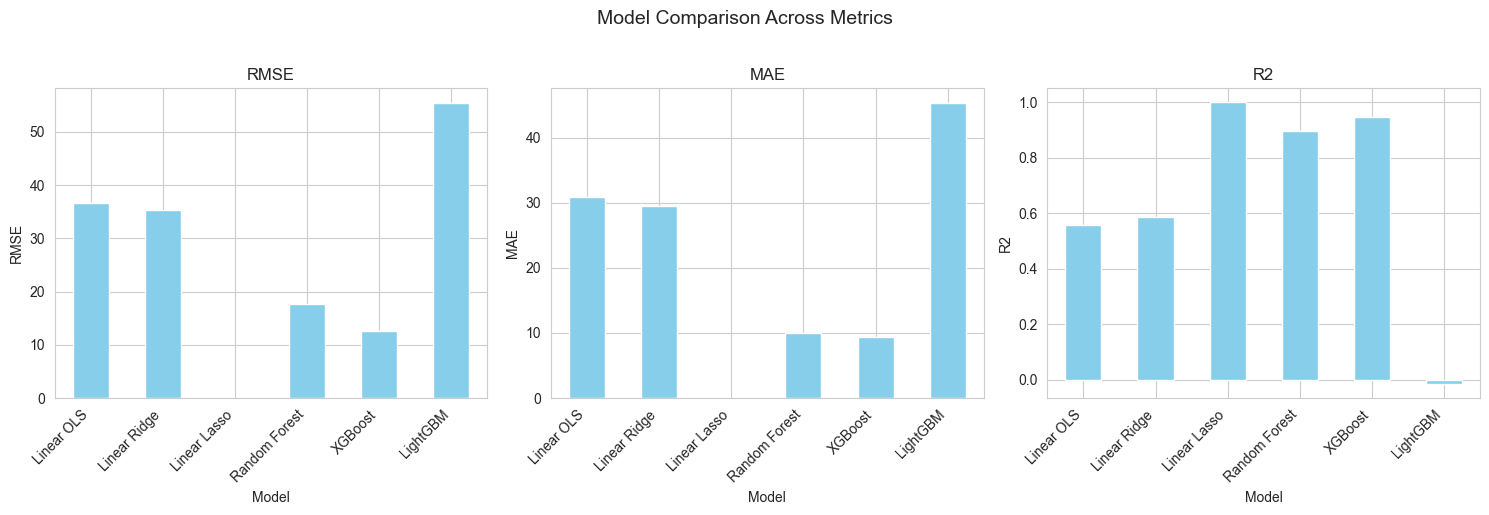


Best model: Linear Lasso (RMSE: 0.058121)


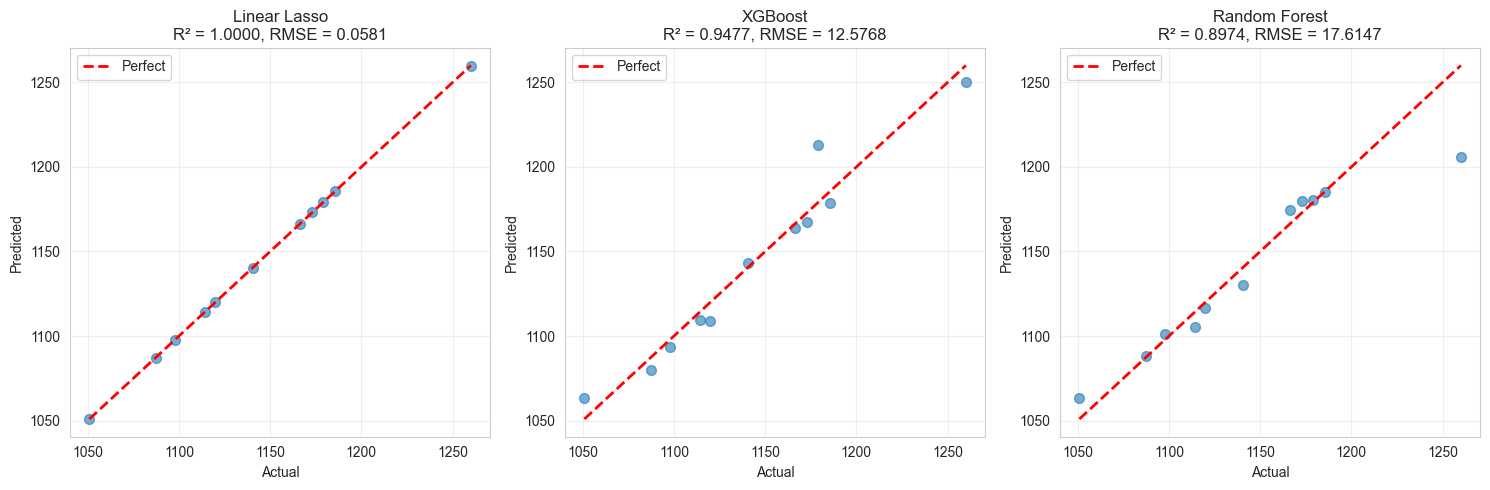

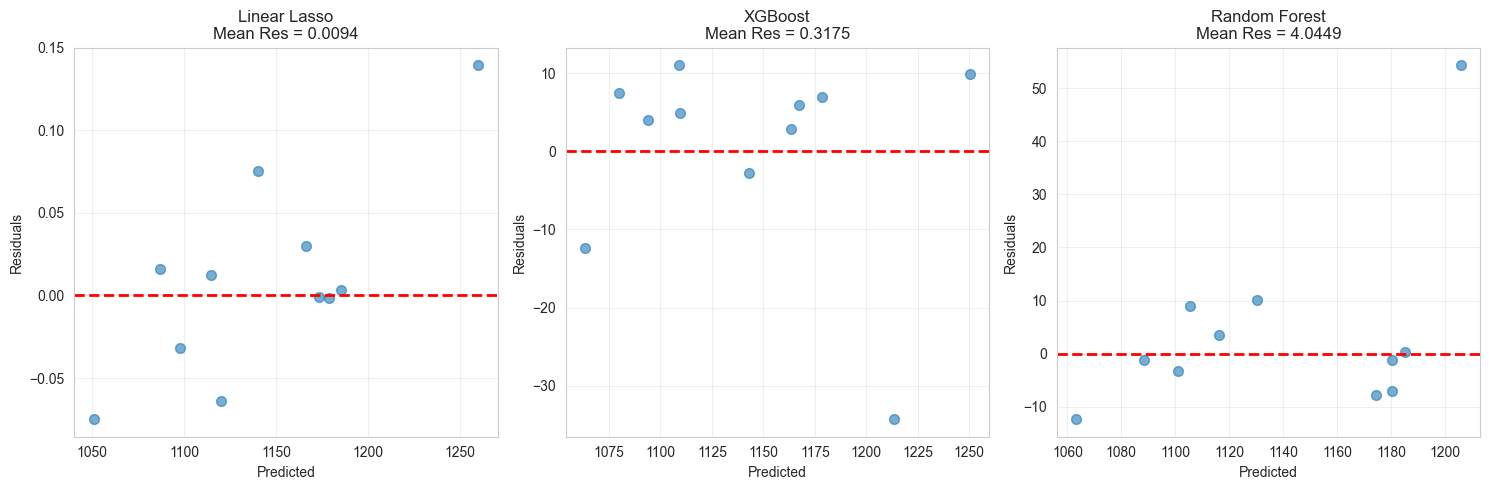

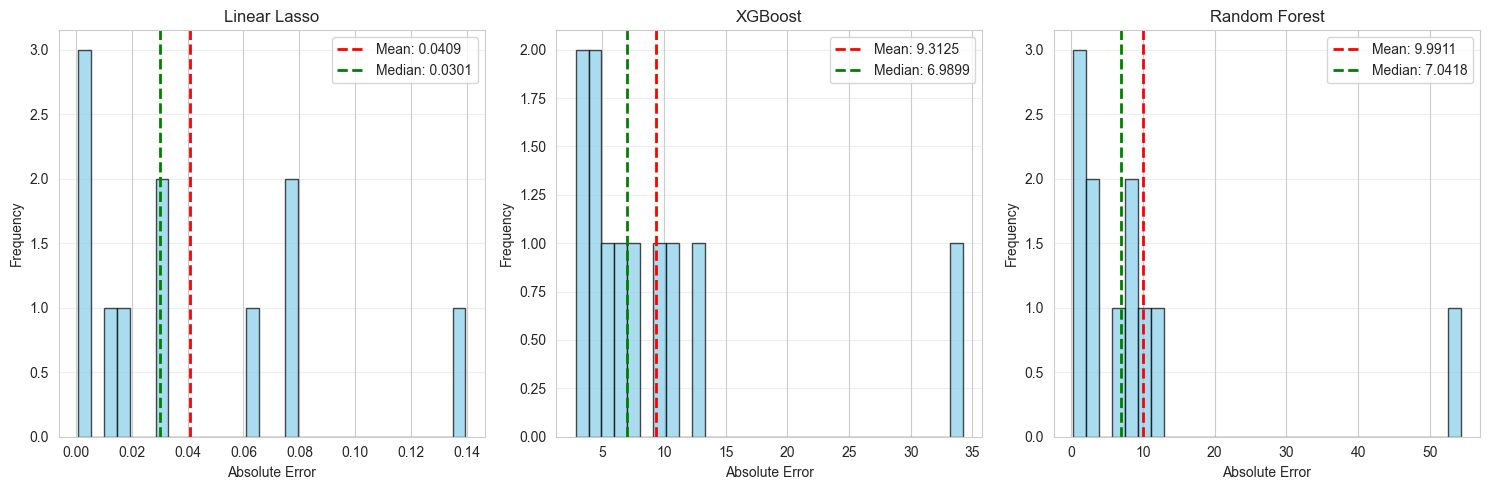

In [ ]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Model Comparison - RMSE
fig = comparator.plot_comparison(metrics=['RMSE', 'MAE', 'R2'], figsize=(15, 5))
plt.suptitle('Model Comparison Across Metrics', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('results/model_comparison_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

# 2. Predictions vs Actual for top 3 models
best_model_name, best_rmse = comparator.get_best_model('RMSE')
print(f"\nBest model: {best_model_name} (RMSE: {best_rmse:.6f})")

# Get top 3 models by RMSE
top_3_models = comparison_df['RMSE'].nsmallest(3).index.tolist()
top_3_preds = {name: all_predictions[name] for name in top_3_models}

fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    r2 = comparison_df.loc[model_name, 'R2']
    rmse = comparison_df.loc[model_name, 'RMSE']
    
    ax.scatter(y_test, preds, alpha=0.6, s=50)
    
    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{model_name}\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('results/predictions_vs_actual_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 3. Residuals plot for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    residuals = y_test - preds
    
    ax.scatter(preds, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model_name}\nMean Res = {residuals.mean():.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/residuals_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 4. Error distribution for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    errors = np.abs(y_test - preds)
    
    ax.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean: {errors.mean():.4f}')
    ax.axvline(np.median(errors), color='g', linestyle='--', lw=2, label=f'Median: {np.median(errors):.4f}')
    
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/error_distribution_top3.png', dpi=100, bbox_inches='tight')
plt.show()

Added Random Forest feature importances
Added Linear OLS coefficients
Added Linear Ridge coefficients
Added Linear Lasso coefficients

Random Forest - Top 15 Features:
1. Engine RPM[RPM]_mean: 0.365312
2. Engine RPM[RPM]_q25: 0.168424
3. Engine RPM[RPM]_median: 0.094141
4. Engine RPM[RPM]_cv: 0.024383
5. HV Battery SOC[%]_cv: 0.024003
6. Absolute Load[%]_mean: 0.017932
7. HV Battery SOC[%]_mean: 0.017101
8. MAF[g/sec]_mean: 0.016308
9. Engine RPM[RPM]_mode_count: 0.015685
10. HV Battery SOC[%]_std: 0.014889
11. MAF[g/sec]_q75: 0.013622
12. MAF[g/sec]_sum: 0.011712
13. MAF[g/sec]_median: 0.009902
14. HV Battery Voltage[V]_mean: 0.009644
15. Long Term Fuel Trim Bank 1[%]_std: 0.009487

Linear OLS - Top 15 Features:
1. Engine RPM[RPM]_q75: 6.922011
2. Engine RPM[RPM]_mean: 5.785168
3. Engine RPM[RPM]_median: 5.342562
4. Vehicle Speed[km/h]_std: 4.150496
5. MAF[g/sec]_mode_count: 4.027641
6. Engine RPM[RPM]_mode_count: 3.737704
7. Absolute Load[%]_mean: 3.657242
8. Air Conditioning Power[W

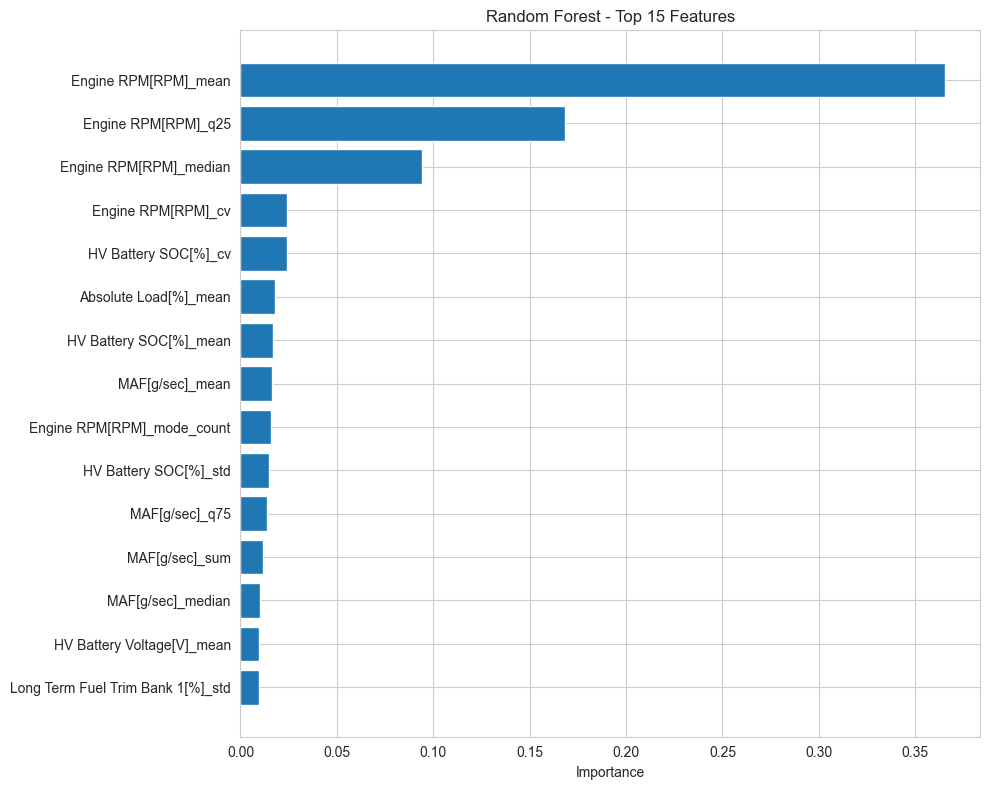

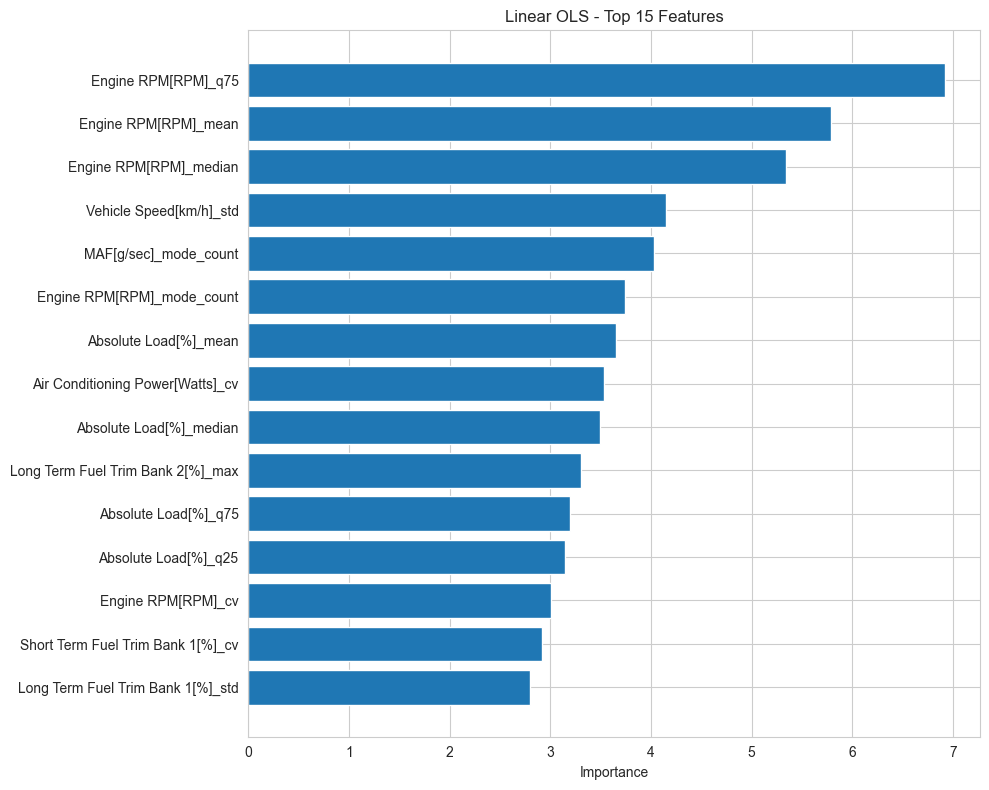

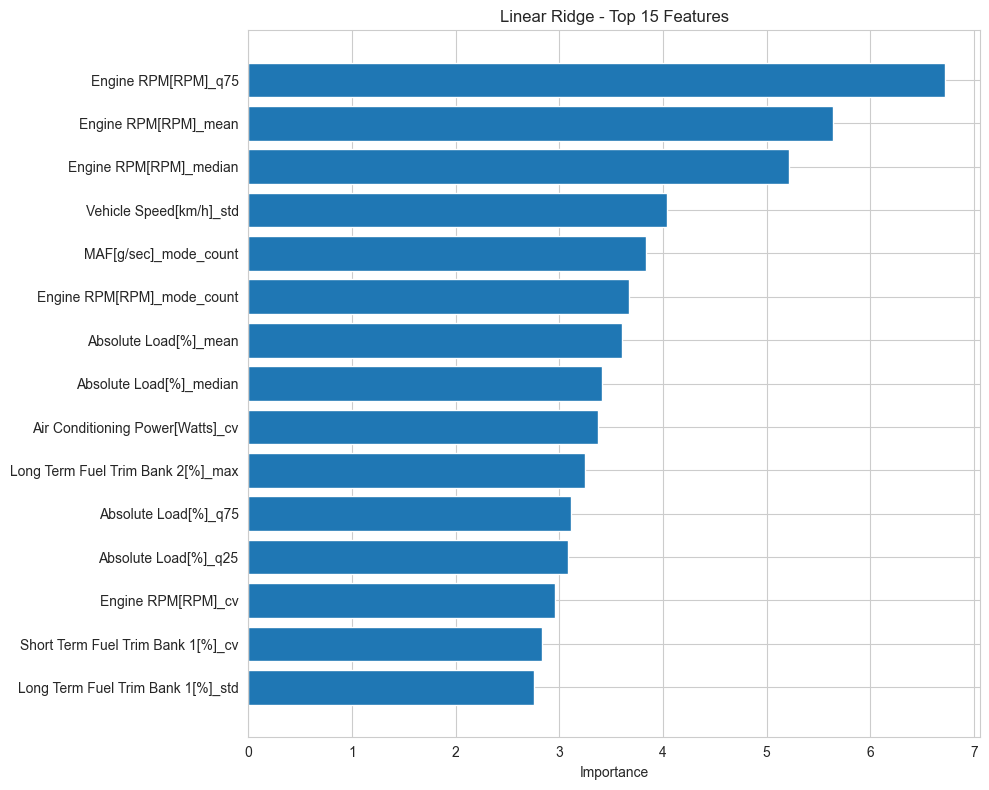

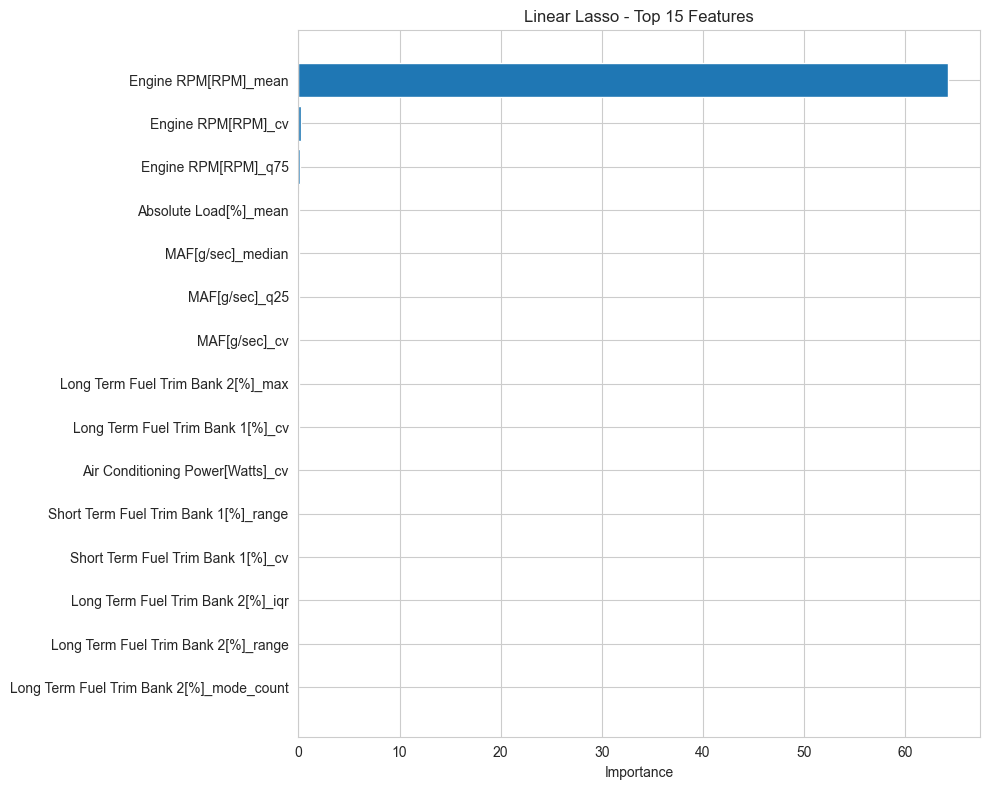

In [ ]:
analyzer = FeatureImportanceAnalyzer(feature_cols)

# Extract feature importance from tree-based models
if hasattr(all_models['Random Forest'], 'feature_importances_'):
    importance = all_models['Random Forest'].feature_importances_
    analyzer.add_importance('Random Forest', importance, 'importance')
    print("Added Random Forest feature importances")

if hasattr(all_models['XGBoost'], 'feature_importances_'):
    importance = all_models['XGBoost'].feature_importances_
    analyzer.add_importance('XGBoost', importance, 'importance')
    print("Added XGBoost feature importances")

if hasattr(all_models['LightGBM'], 'feature_importances_'):
    importance = all_models['LightGBM'].feature_importances_
    analyzer.add_importance('LightGBM', importance, 'importance')
    print("Added LightGBM feature importances")

# Add linear coefficients (absolute values)
if hasattr(all_models['Linear OLS'], 'coef_'):
    importance = np.abs(all_models['Linear OLS'].coef_)
    analyzer.add_importance('Linear OLS', importance, 'coefficient')
    print("Added Linear OLS coefficients")

if hasattr(all_models['Linear Ridge'], 'coef_'):
    importance = np.abs(all_models['Linear Ridge'].coef_)
    analyzer.add_importance('Linear Ridge', importance, 'coefficient')
    print("Added Linear Ridge coefficients")

if hasattr(all_models['Linear Lasso'], 'coef_'):
    importance = np.abs(all_models['Linear Lasso'].coef_)
    analyzer.add_importance('Linear Lasso', importance, 'coefficient')
    print("Added Linear Lasso coefficients")

# Print summary
analyzer.print_summary(n=15)

# Plot feature importance for all models
Path('results').mkdir(exist_ok=True)
for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']:
    if model_name in analyzer.importances:
        fig = analyzer.plot_feature_importance(model_name, n=15, figsize=(10, 8))
        plt.tight_layout()
        plt.savefig(f'results/feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                   dpi=100, bbox_inches='tight')
        plt.show()

In [ ]:
best_model_name, best_rmse = comparator.get_best_model('RMSE')
best_mae = comparator.get_best_model('MAE')[1]
best_r2 = comparator.get_best_model('R2')[1]

print(f"\nBEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.6f}")
print(f"MAE:  {best_mae:.6f}")
print(f"R²:   {best_r2:.6f}")

print("\nMODEL RANKING (by RMSE):")
ranking = comparison_df.sort_values('RMSE')
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {model:20s} | RMSE: {row['RMSE']:10.6f} | MAE: {row['MAE']:10.6f} | R²: {row['R2']:8.6f}")

print("\nMETRICS INTERPRETATION")
print("""
RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = perfect, 0.0 = no better than mean
  - Higher is better

MAPE (Mean Absolute Percentage Error):
  - Percentage error relative to actual values
  - Useful for comparing across scales
  - Lower is better (%)
""")

# Create directories if they don't exist
Path('models/saved_models').mkdir(parents=True, exist_ok=True)

# Save all models with joblib
for model_name, model in all_models.items():
    joblib.dump(model, f'models/saved_models/{model_name.replace(" ", "_")}.pkl')
    print(f"Saved {model_name}")

# Save scaler
joblib.dump(scaler, 'models/saved_models/feature_scaler.pkl')
print("Saved feature scaler")

print(f"""
Results saved to:
  - results/model_comparison.csv (metrics table)
  - results/model_comparison_metrics.png (comparison plot)
  - results/predictions_vs_actual_top3.png (predictions plot)
  - results/residuals_top3.png (residuals plot)
  - results/error_distribution_top3.png (error distribution)
  - results/feature_importance_*.png (feature importance plots)

Models saved to:
  - models/saved_models/[model_name].pkl
  - models/saved_models/feature_scaler.pkl
""")


BEST MODEL: Linear Lasso
RMSE: 0.058121
MAE:  0.040871
R²:   0.999999

MODEL RANKING (by RMSE):
1. Linear Lasso         | RMSE:   0.058121 | MAE:   0.040871 | R²: 0.999999
2. XGBoost              | RMSE:  12.576792 | MAE:   9.312461 | R²: 0.947685
3. Random Forest        | RMSE:  17.614657 | MAE:   9.991135 | R²: 0.897378
4. Linear Ridge         | RMSE:  35.359392 | MAE:  29.532897 | R²: 0.586477
5. Linear OLS           | RMSE:  36.620880 | MAE:  30.803770 | R²: 0.556444
6. LightGBM             | RMSE:  55.420885 | MAE:  45.285297 | R²: -0.015868

METRICS INTERPRETATION

RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = perfect, 0.0 = no better than mean
  - Higher is better

MAPE (Mean Absolute Perc